<a href="https://colab.research.google.com/github/Gaurav1401/Credit_Risk_Modelling/blob/main/Credit_Risk_Tree_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, recall_score
from sklearn.metrics import precision_recall_curve
import warnings as wg
wg.filterwarnings('ignore')

# Libraries to visualize DT
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [ ]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv("/content/credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df['loan_status'].value_counts()/df.shape[0]

0    0.781312
1    0.218688
Name: loan_status, dtype: float64

In [ ]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [ ]:
# The records of F and G are extremely less. So, merging E,F,G
df['loan_grade'].value_counts()

A    10703
B    10387
C     6438
D     3620
E      963
F      241
G       64
Name: loan_grade, dtype: int64

In [ ]:
df['loan_grade'] = df['loan_grade'].replace(["E", 'F', 'G'], 'other')

In [ ]:
df['loan_grade'].value_counts()

A        10703
B        10387
C         6438
D         3620
other     1268
Name: loan_grade, dtype: int64

**From the domain knowledge, we can understand that loan_int_rate wil be dependent on loan_grade**

In [ ]:
df[['loan_grade', 'loan_int_rate']].groupby('loan_grade')['loan_int_rate'].mean()

loan_grade
A         7.328423
B        10.995756
C        13.464579
D        15.360698
other    17.471466
Name: loan_int_rate, dtype: float64

In [ ]:
# df[df['loan_grade'] == 'A']['loan_int_rate'].fillna(7.32, inplace = True)
# df[df['loan_grade'] == 'B']['loan_int_rate'] = df[df['loan_grade'] == 'B']['loan_int_rate'].fillna(10.99)
# df[df['loan_grade'] == 'C']['loan_int_rate'] = df[df['loan_grade'] == 'C']['loan_int_rate'].fillna(13.46)
# df[df['loan_grade'] == 'D']['loan_int_rate'] = df[df['loan_grade'] == 'D']['loan_int_rate'].fillna(15.36)
# df[df['loan_grade'] == 'other']['loan_int_rate'] = df[df['loan_grade'] == 'other']['loan_int_rate'].fillna(17.47)

In [ ]:
df['loan_int_rate'] = df['loan_int_rate'].fillna(df.groupby('loan_grade')['loan_int_rate'].transform('mean'))

In [ ]:
df.isna().sum()

person_age                      0
person_income                   0
person_home_ownership           0
person_emp_length             887
loan_intent                     0
loan_grade                      0
loan_amnt                       0
loan_int_rate                   0
loan_status                     0
loan_percent_income             0
cb_person_default_on_file       0
cb_person_cred_hist_length      0
dtype: int64

In [ ]:
df.dropna(inplace = True)

### **Dummy variable and label encoding**

In [ ]:
# Label Encoding

df['cb_person_default_on_file'] = df['cb_person_default_on_file'].replace({'Y':1, 'N':0})
df['loan_grade'] = df['loan_grade'].replace({'A':1, 'B':2, 'C':3, 'D':4, 'other':5})

In [ ]:
# Dummy variable encoding

ownership_dummies = pd.get_dummies(df.person_home_ownership, drop_first = True)
intent_dummies = pd.get_dummies(df.loan_intent, drop_first = True)

In [ ]:
df.drop(['person_home_ownership', 'loan_intent'], axis = 'columns', inplace = True)
final = pd.concat([df, ownership_dummies, intent_dummies], axis = 'columns')

### **Train Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final.drop('loan_status', axis = 'columns'),
                                                    final['loan_status'],
                                                    test_size = 0.2,
                                                    stratify = final['loan_status'],
                                                    random_state = 0)

print("Number of records in training set:", X_train.shape)
print("Number of records in testing set:", X_test.shape)

Number of records in training set: (25223, 17)
Number of records in testing set: (6306, 17)


### **Base Decision Tree**

In [ ]:
model = DecisionTreeClassifier()

In [ ]:
model.fit(X_train, y_train)

print("Initial training f1 score:", f1_score(y_train, model.predict(X_train)))
print("Initial testing f1 score:", f1_score(y_test, model.predict(X_test)))

Initial training f1 score: 1.0
Initial testing f1 score: 0.7480860371855632


In [ ]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

### **Hyperparameter Tuning**

In [ ]:
param_grid = {
    "criterion" : ['gini', 'entropy'],
    "splitter" : ['best', 'random'],
    "max_depth" : [3, 4, 5],
    "min_samples_leaf": [100, 200],
    "min_samples_split" : [0.1 ,0.2]
}

In [ ]:
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'recall', cv=5, return_train_score=False)
clf.fit(X_train, y_train)
clf.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 100,
 'min_samples_split': 0.2,
 'splitter': 'best'}

### **Final Decision Tree**

In [ ]:
model1 = DecisionTreeClassifier(criterion= 'gini',
                                max_depth= 3,
                                min_samples_leaf = 100,
                                min_samples_split = 0.2,
                                splitter = 'best',
                                random_state = 0)

model1.fit(X_train, y_train)

print("Initial training f1 score:", f1_score(y_train, model1.predict(X_train)))
print("Initial testing f1 score:", f1_score(y_test, model1.predict(X_test)))

Initial training f1 score: 0.6948333333333333
Initial testing f1 score: 0.6903485254691689


In [ ]:
model1.predict_proba(X_train)[:,1]

array([0.06840216, 0.06840216, 0.06840216, ..., 0.06840216, 0.06840216,
       0.56411062])

In [ ]:
model2 = DecisionTreeClassifier(criterion= 'entropy',
                                max_depth= 6, # 3
                                min_samples_split = 2,
                                splitter = 'best',
                                class_weight = {0: 0.63768519,
                                                1: 2.31573632},
                                random_state = 0)

model2.fit(X_train, y_train)

print("Initial training f1 score:", f1_score(y_train, model2.predict(X_train)))
print("Initial testing f1 score:", f1_score(y_test, model2.predict(X_test)))

Initial training f1 score: 0.7565993082104496
Initial testing f1 score: 0.74899230487358


In [ ]:
print("Decision Tree f1 Score on training data",f1_score(y_train, model2.predict(X_train)))
print("Decision Tree ROC AUC Score on training data",roc_auc_score(y_train, model2.predict(X_train)))
print("Decision Tree Recall Score on training data",recall_score(y_train, model2.predict(X_train)))

Decision Tree f1 Score on training data 0.7565993082104496
Decision Tree ROC AUC Score on training data 0.8465743109115036
Decision Tree Recall Score on training data 0.7631289019463827


In [ ]:
print("Decision Tree f1 Score on testing data",f1_score(y_test, model2.predict(X_test)))
print("Decision Tree ROC AUC Score on testing data",roc_auc_score(y_test, model2.predict(X_test)))
print("Decision Tree Recall Score on testing data",recall_score(y_test, model2.predict(X_test)))

Decision Tree f1 Score on testing data 0.74899230487358
Decision Tree ROC AUC Score on testing data 0.8402927768986213
Decision Tree Recall Score on testing data 0.750367107195301


### **Feature Importance**

In [ ]:
model2.feature_importances_

array([0.00166853, 0.12849907, 0.01990534, 0.31762183, 0.        ,
       0.01295814, 0.28724009, 0.        , 0.        , 0.        ,
       0.03507716, 0.14150912, 0.00815718, 0.01431029, 0.02331388,
       0.0009221 , 0.00881727])

In [ ]:
feature_imp = pd.DataFrame()
feature_imp['features'] = X_train.columns
feature_imp['scores'] = model2.feature_importances_

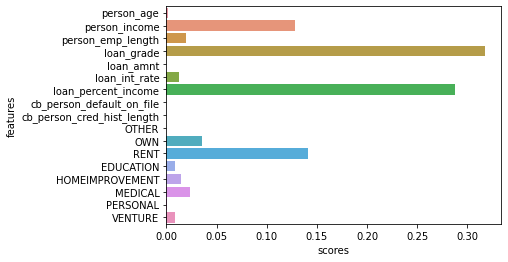

In [ ]:
sns.barplot(x = 'scores', y = 'features', data = feature_imp)
# plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.show()

In [ ]:
ks_dt_train = pd.DataFrame()
ks_dt_train['probabilities'] = list(model2.predict_proba(X_train)[:, 1])
ks_dt_train['target'] = list(y_train)
ks_dt_train = ks_dt_train.sort_values(by="probabilities", ascending=False).reset_index(drop = True)

In [ ]:
ks_dt_test = pd.DataFrame()
ks_dt_test['probabilities'] = list(model2.predict_proba(X_test)[:, 1])
ks_dt_test['target'] = list(y_test)
ks_dt_test = ks_dt_test.sort_values(by="probabilities", ascending=False).reset_index(drop = True)

In [ ]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['rownum'] = 1
    data['rownum'] = data['rownum'].cumsum()
    data.sort_values(by=prob,ascending=False,inplace=True)
    data['bucket'] = pd.cut(data['rownum'], 10) #, duplicates='drop'     grouped = data.groupby('bucket', as_index = False)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [ ]:
X = ks(data = ks_dt_train, target = 'target', prob = 'probabilities')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       1.000000  1.000000    2523          0     46.33%         0.00%   
2       0.573243  1.000000    1502       1020     27.58%         5.16%   
3       0.267056  0.573243     376       2146      6.90%        10.85%   
4       0.267056  0.267056     230       2292      4.22%        11.59%   
5       0.267056  0.267056     229       2294      4.20%        11.60%   
6       0.190576  0.267056     207       2315      3.80%        11.71%   
7       0.190576  0.190576     171       2351      3.14%        11.89%   
8       0.190576  0.190576     140       2382      2.57%        12.04%   
9       0.057877  0.190576      52       2470      0.95%        12.49%   
10      0.000000  0.057877      16       2507      0.29%        12.68%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             46.33

In [ ]:
X = ks(data = ks_dt_test, target = 'target', prob = 'probabilities')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       1.000000  1.000000     631          0     46.33%         0.00%   
2       0.573243  1.000000     352        279     25.84%         5.64%   
3       0.267056  0.573243     120        510      8.81%        10.32%   
4       0.267056  0.267056      58        573      4.26%        11.59%   
5       0.267056  0.267056      55        575      4.04%        11.63%   
6       0.190576  0.267056      51        580      3.74%        11.73%   
7       0.190576  0.190576      29        601      2.13%        12.16%   
8       0.190576  0.190576      52        579      3.82%        11.71%   
9       0.057877  0.190576       9        621      0.66%        12.56%   
10      0.000000  0.057877       5        626      0.37%        12.66%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             46.33

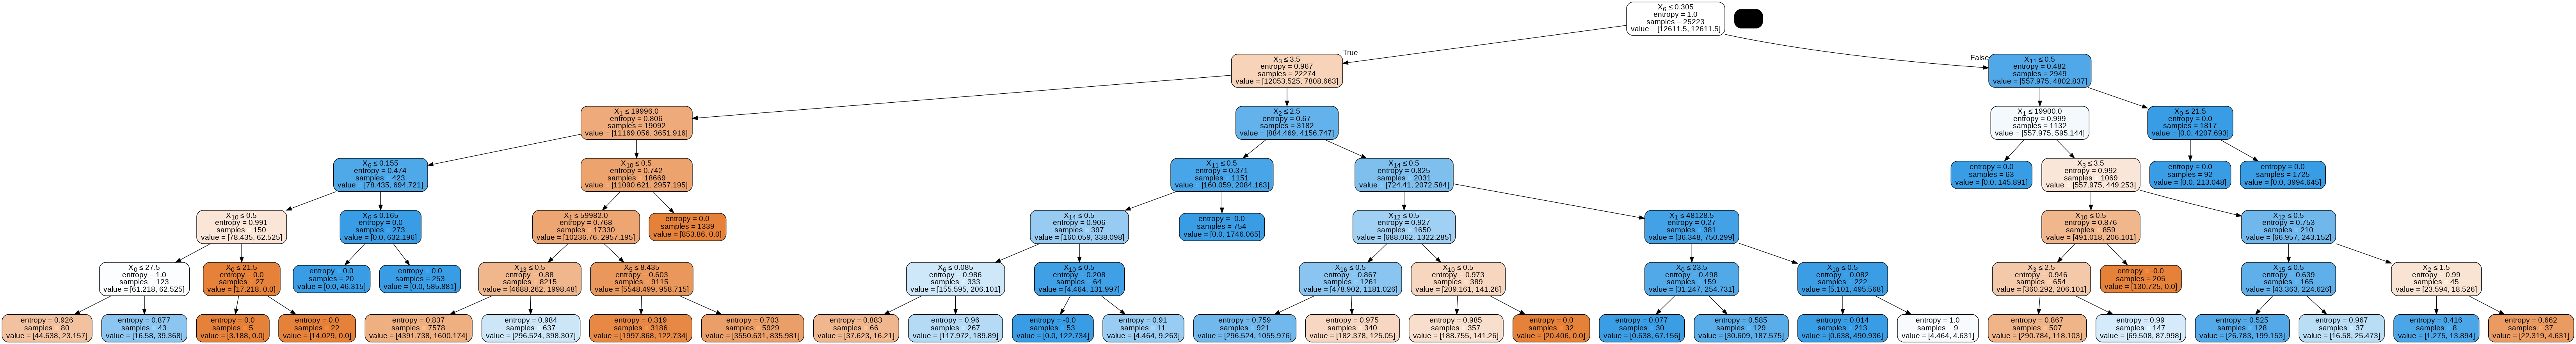

In [ ]:
dot_data = StringIO()
export_graphviz(model2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
X_train.loc[0,:]

person_age                       22.00
person_income                 59000.00
person_emp_length               123.00
loan_grade                        4.00
loan_amnt                     35000.00
loan_int_rate                    16.02
loan_percent_income               0.59
cb_person_default_on_file         1.00
cb_person_cred_hist_length        3.00
OTHER                             0.00
OWN                               0.00
RENT                              1.00
EDUCATION                         0.00
HOMEIMPROVEMENT                   0.00
MEDICAL                           0.00
PERSONAL                          1.00
VENTURE                           0.00
Name: 0, dtype: float64

### **Base Random Forest**

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

print("Initial training f1 score:", f1_score(y_train, model.predict(X_train)))
print("Initial testing f1 score:", f1_score(y_test, model.predict(X_test)))

Initial training f1 score: 0.9997244926072184
Initial testing f1 score: 0.8271186440677967


In [ ]:
param_grid2 = {
    "criterion" : ['gini', 'entropy'],
    "max_depth" : [3, 5, 9, 10],
    "min_samples_leaf": [150, 200, 300],
    "min_samples_split" : [0.1 ,0.2],
    "n_estimators": [20, 50, 100,200]
}

In [ ]:
# clf2 = GridSearchCV(RandomForestClassifier(), param_grid2,scoring = 'roc_auc', cv=5, return_train_score=False)
# clf2.fit(X_train, y_train)
# clf2.best_params_

### **Final Random Forest**

In [ ]:
forest1 = RandomForestClassifier(criterion= 'gini',
                                  max_depth= 10,
                                  min_samples_leaf= 150,
                                  min_samples_split= 0.1,
                                  n_estimators= 200,
                                random_state = 0)

forest1.fit(X_train, y_train)

print("Initial training f1 score:", f1_score(y_train, forest1.predict(X_train)))
print("Initial testing f1 score:", f1_score(y_test, forest1.predict(X_test)))

Initial training f1 score: 0.7003549801628731
Initial testing f1 score: 0.7034883720930232


In [ ]:
print("Random Forest f1 Score on training data",f1_score(y_train, forest1.predict(X_train)))
print("Random Forest ROC AUC Score on training data",roc_auc_score(y_train, forest1.predict(X_train)))
print("Random Forest Recall Score on training data",recall_score(y_train, forest1.predict(X_train)))

Random Forest f1 Score on training data 0.7003549801628731
Random Forest ROC AUC Score on training data 0.7882631146315572
Random Forest Recall Score on training data 0.615864854939405


In [ ]:
print("Random Forest f1 Score on testing data", f1_score(y_test, forest1.predict(X_test)))
print("Random Forest ROC AUC Score on testing data", roc_auc_score(y_test, forest1.predict(X_test)))
print("Random Forest Recall Score on testing data", recall_score(y_test, forest1.predict(X_test)))

Random Forest f1 Score on testing data 0.7034883720930232
Random Forest ROC AUC Score on testing data 0.7908143898892261
Random Forest Recall Score on testing data 0.6218795888399412


In [ ]:
prob_train = forest1.predict_proba(X_train)[:, 1]
prob_test = forest1.predict_proba(X_test)[:, 1]

# y_predict1 = forest1.predict(X_train)

In [ ]:
forest1.feature_importances_

array([5.68916743e-04, 1.23698879e-01, 2.36530746e-03, 2.54471991e-01,
       2.75690264e-02, 1.52146670e-01, 3.62330317e-01, 2.10719115e-02,
       6.16137071e-05, 0.00000000e+00, 3.84914538e-03, 4.40475361e-02,
       4.65085012e-04, 2.61325595e-03, 1.14951676e-03, 2.87759958e-05,
       3.56205235e-03])

In [ ]:
feature_imp = pd.DataFrame()
feature_imp['features'] = X_train.columns
feature_imp['scores'] = forest1.feature_importances_

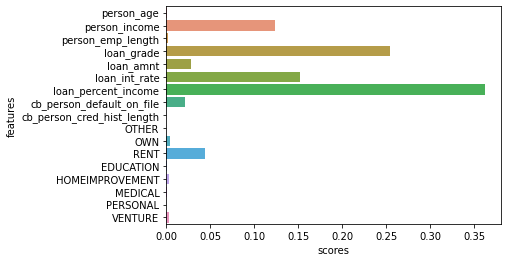

In [ ]:
sns.barplot(x = 'scores', y = 'features', data = feature_imp)
plt.show()

In [ ]:
ks_forest_train = pd.DataFrame()
ks_forest_train['probabilities'] = list(prob_train)
ks_forest_train['target'] = list(y_train)
ks_forest_train = ks_forest_train.sort_values(by="probabilities", ascending=False).reset_index(drop = True)

X = ks(data = ks_forest_train, target = 'target', prob = 'probabilities')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.554584  0.684153    2377        146     43.65%         0.74%   
2       0.473253  0.554513    1369       1153     25.14%         5.83%   
3       0.216004  0.473234     628       1894     11.53%         9.58%   
4       0.154183  0.215981     314       2208      5.77%        11.16%   
5       0.117157  0.154152     232       2291      4.26%        11.58%   
6       0.093343  0.117148     193       2329      3.54%        11.78%   
7       0.077592  0.093333     161       2361      2.96%        11.94%   
8       0.063903  0.077591      91       2431      1.67%        12.29%   
9       0.049660  0.063897      62       2460      1.14%        12.44%   
10      0.023277  0.049657      19       2504      0.35%        12.66%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             43.65

In [ ]:
ks_forest_test = pd.DataFrame()
ks_forest_test['probabilities'] = list(prob_test)
ks_forest_test['target'] = list(y_test)
ks_forest_test = ks_forest_test.sort_values(by="probabilities", ascending=False).reset_index(drop = True)

X = ks(data = ks_forest_test, target = 'target', prob = 'probabilities')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.552975  0.681180     600         31     44.05%         0.63%   
2       0.472056  0.552842     327        304     24.01%         6.15%   
3       0.214380  0.472056     152        478     11.16%         9.67%   
4       0.153560  0.214209      81        550      5.95%        11.12%   
5       0.116996  0.153503      73        557      5.36%        11.27%   
6       0.092968  0.116936      44        587      3.23%        11.87%   
7       0.078364  0.092952      34        596      2.50%        12.06%   
8       0.064901  0.078360      22        609      1.62%        12.32%   
9       0.050954  0.064880      22        608      1.62%        12.30%   
10      0.023782  0.050952       7        624      0.51%        12.62%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             44.05

In [ ]:
# capture rate
X.cum_eventrate

Decile
1      44.05%
2      68.06%
3      79.22%
4      85.17%
5      90.53%
6      93.76%
7      96.26%
8      97.87%
9      99.49%
10    100.00%
Name: cum_eventrate, dtype: object

In [ ]:
feature_importance = pd.DataFrame()
feature_importance['columns'] = X_train.columns
feature_importance['importance_score'] = forest1.feature_importances_

In [ ]:
feature_importance

,columns,importance_score
0,person_age,0.000569
1,person_income,0.123699
2,person_emp_length,0.002365
3,loan_grade,0.254472
4,loan_amnt,0.027569
5,loan_int_rate,0.152147
6,loan_percent_income,0.362330
7,cb_person_default_on_file,0.021072
8,cb_person_cred_hist_length,0.000062
9,OTHER,0.000000
